First, import needed modules

In [103]:
import numpy as np
import pandas as pd
import os
import geopandas as gpd
import matplotlib.pyplot as plt
import shapely.speedups
from shapely import wkt
from shapely.ops import unary_union

Initalize variables

In [104]:
shapely.speedups.enable()
path = os.getcwd()
print(path)

/Users/jan/Dropbox/UP_EPQM/2222/MA/powerlinemonsters


Load shapefile with municipality and state boundaries and plot it for inspection

<AxesSubplot:>

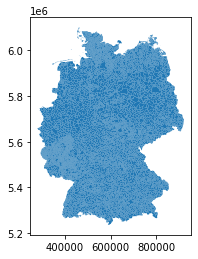

In [105]:
municipalities = gpd.read_file(f'{path}/data/geodata/VG250_GEM.shp')
municipalities.index.rename('ID', inplace=True)
states = gpd.read_file(f'{path}/data/geodata/VG250_LAN.shp')
municipalities.plot()

Inspect the dataframe: GEN has the municipalities' names, geometry are the polygons.


In [106]:
municipalities.head()

,ADE,GF,BSG,RS,AGS,SDV_RS,GEN,BEZ,IBZ,BEM,...,SN_V2,SN_G,FK_S3,NUTS,RS_0,AGS_0,WSK,EWZ,DEBKG_ID,geometry
ID,,,,,,,,,,,,,,,,,,,,,
0,6,2,1,083355004002,08335002,083355004002,Allensbach,Gemeinde,64,gemeinschaftsangehörig,...,04,002,R,DE138,083355004002,08335002,2009-01-01,0,DEBKGDL20000HKND,"POLYGON ((507883.567 5282624.777, 507923.277 5..."
1,6,2,1,083355004066,08335066,083355004066,Reichenau,Gemeinde,64,gemeinschaftsangehörig,...,04,066,R,DE138,083355004066,08335066,2009-01-01,0,DEBKGDL20000HKNF,"MULTIPOLYGON (((508095.875 5281959.799, 508134..."
2,6,2,1,083350063063,08335063,083350063063,Radolfzell am Bodensee,Stadt,61,None,...,63,063,R,DE138,083350063063,08335063,2009-01-01,0,DEBKGDL20000HKNE,"POLYGON ((500719.668 5285290.972, 500632.566 5..."
3,6,2,1,010595990186,01059186,010595990186,Steinbergkirche,Gemeinde,64,gemeinschaftsangehörig,...,90,186,R,DEF0C,010595990186,01059186,2013-03-01,0,DEBKGDL20000XYFA,"POLYGON ((547082.162 6075557.922, 547528.602 6..."
4,6,2,1,033595407018,03359018,033595407018,Freiburg (Elbe),Gemeinde,64,gemeinschaftsangehörig,...,07,018,K,DE939,033595407018,03359018,2009-01-01,0,DEBKGDL20000QMG4,"POLYGON ((517934.141 5968832.380, 519053.640 5..."


Check for duplicates in terms of the AGS (Amtlicher Gemeindeschlüssel) -> there are duplicates.

In [107]:
municipalities['ags_dup'] = municipalities.duplicated(subset=['AGS'], keep=False)
municipalities = municipalities.sort_values(by=['AGS'])
municipalities.head()

,ADE,GF,BSG,RS,AGS,SDV_RS,GEN,BEZ,IBZ,BEM,...,SN_G,FK_S3,NUTS,RS_0,AGS_0,WSK,EWZ,DEBKG_ID,geometry,ags_dup
ID,,,,,,,,,,,,,,,,,,,,,
10108,6,4,1,010010000000,01001000,010010000000,Flensburg,Stadt,60,kreisfrei,...,000,R,DEF01,010010000000,01001000,2008-01-01,83971,DEBKGDL20000E5MA,"POLYGON ((526513.753 6075133.412, 526547.941 6...",True
81,6,2,1,010010000000,01001000,010010000000,Flensburg,Stadt,60,kreisfrei,...,000,R,DEF01,010010000000,01001000,2008-01-01,0,DEBKGDL20000003H,"POLYGON ((531003.439 6076758.957, 531473.283 6...",True
9982,6,4,1,010020000000,01002000,010020000000,Kiel,Stadt,60,kreisfrei,...,000,R,DEF02,010020000000,01002000,2004-12-31,241533,DEBKGDL20000004J,"POLYGON ((575841.569 6032148.032, 575869.668 6...",True
83,6,2,1,010020000000,01002000,010020000000,Kiel,Stadt,60,kreisfrei,...,000,R,DEF02,010020000000,01002000,2004-12-31,0,DEBKGDL20000E6XX,"MULTIPOLYGON (((574823.567 6024461.716, 574857...",True
10930,6,4,1,010030000000,01003000,010030000000,Lübeck,Stadt,60,kreisfrei,...,000,R,DEF03,010030000000,01003000,2006-02-01,212958,DEBKGDL20000DYMA,"POLYGON ((623056.151 5983746.445, 623191.574 5...",False


Create duplicates df and inspect

In [108]:
duplicates = municipalities[municipalities['ags_dup'] == True] # create duplicates df
duplicates.insert(loc=len(duplicates.columns), column='union', value=0) # insert a empty 'union' column
duplicates.sort_values(by=['AGS']) # sort by city name
print(duplicates['AGS'].describe(include='object')) # 264 values, 132 are unique = 2 observations per AGS

count          264
unique         132
top       01001000
freq             2
Name: AGS, dtype: object


Merge shapes for the duplicate municipalities

In [109]:
for i in range(0, len(duplicates), 2): # iterate over all duplicate cities, step = 2 because 2 obs. per city
    AGS = duplicates.iloc[i, 4] # get the AGS
    duplicate = duplicates[duplicates['AGS'] == AGS] # returns 'duplicate' geodataframe for each city
    duplicates['union'].loc[duplicates.index[i]] = duplicate.unary_union # combine the shapes
duplicates = duplicates[duplicates['union'] != 0 ] # drop the duplicates, keep only the combined shapes
duplicates = duplicates.drop(columns=['geometry']) # drop the geometry column
duplicates.rename(columns = {'union':'geometry'}, inplace = True)   #rename the union column to geometry
duplicates.head()

/var/folders/wm/mtrphj0s0msgrmyshf3hgk740000gn/T/ipykernel_25961/3266038290.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  duplicates['union'].loc[duplicates.index[i]] = duplicate.unary_union # combine the shapes
/var/folders/wm/mtrphj0s0msgrmyshf3hgk740000gn/T/ipykernel_25961/3266038290.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  duplicates['union'].loc[duplicates.index[i]] = duplicate.unary_union # combine the shapes
/var/folders/wm/mtrphj0s0msgrmyshf3hgk740000gn/T/ipykernel_25961/3266038290.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats 

,ADE,GF,BSG,RS,AGS,SDV_RS,GEN,BEZ,IBZ,BEM,...,SN_G,FK_S3,NUTS,RS_0,AGS_0,WSK,EWZ,DEBKG_ID,ags_dup,geometry
ID,,,,,,,,,,,,,,,,,,,,,
10108,6,4,1,010010000000,01001000,010010000000,Flensburg,Stadt,60,kreisfrei,...,000,R,DEF01,010010000000,01001000,2008-01-01,83971,DEBKGDL20000E5MA,True,"POLYGON ((526547.941 6074977.321, 526560.310 6..."
9982,6,4,1,010020000000,01002000,010020000000,Kiel,Stadt,60,kreisfrei,...,000,R,DEF02,010020000000,01002000,2004-12-31,241533,DEBKGDL20000004J,True,"POLYGON ((575865.044 6023231.765, 575892.889 6..."
102,6,2,1,010510011011,01051011,010510011011,Brunsbüttel,Stadt,61,None,...,011,R,DEF05,010510011011,01051011,2009-01-01,0,DEBKGDL20000QMG2,True,"POLYGON ((513131.190 5970200.640, 512770.560 5..."
114,6,2,1,010515178013,01051013,010515178013,Büsum,Gemeinde,64,gemeinschaftsangehörig,...,013,R,DEF05,010515178013,01051013,2011-08-01,0,DEBKGDL20000E5V6,True,"POLYGON ((490754.064 5996799.800, 490709.787 5..."
125,6,2,1,010515166034,01051034,010515166034,Friedrichskoog,Gemeinde,64,gemeinschaftsangehörig,...,034,R,DEF05,010515166034,01051034,2008-01-01,0,DEBKGDL20000SRII,True,"MULTIPOLYGON (((492733.357 5978668.501, 492836..."


Concatenate the duplicates df with the combined shapes to the municipalities df

In [110]:
municipalities = municipalities[municipalities['ags_dup'] == False]
municipalities = gpd.GeoDataFrame(pd.concat([municipalities, duplicates], ignore_index=True), crs=[municipalities, duplicates][0].crs)
municipalities.sort_values(by=['GEN'], inplace=True) # sort by city name
municipalities = municipalities.drop(columns=['ags_dup'])
municipalities.to_csv(f'{path}/data/treatment.csv', encoding = 'utf-8-sig')
municipalities.head()

,ADE,GF,BSG,RS,AGS,SDV_RS,GEN,BEZ,IBZ,BEM,...,SN_V2,SN_G,FK_S3,NUTS,RS_0,AGS_0,WSK,EWZ,DEBKG_ID,geometry
5935,6,4,1,083355001001,08335001,083355001001,Aach,Stadt,63,gemeinschaftsangehörig,...,01,001,R,DE138,083355001001,08335001,2009-01-01,2161,DEBKGDL20000E67B,"POLYGON ((487360.997 5299527.761, 487650.058 5..."
4438,6,4,1,072355007001,07235001,072355007001,Aach,Gemeinde,64,gemeinschaftsangehörig,...,07,001,K,DEB25,072355007001,07235001,2009-01-01,1058,DEBKGDL20000E4CM,"POLYGON ((327525.294 5518625.943, 327584.389 5..."
2116,6,4,1,053340002002,05334002,053340002002,Aachen,Stadt,61,None,...,02,002,R,DEA2D,053340002002,05334002,2009-10-21,241683,DEBKGDL20000E2NA,"MULTIPOLYGON (((292845.650 5637601.948, 292858..."
5520,6,4,1,081365001088,08136088,081365001088,Aalen,Stadt,63,gemeinschaftsangehörig,...,01,088,R,DE11D,081365001088,08136088,2009-01-01,66813,DEBKGDL20000DYJC,"POLYGON ((577663.442 5416758.805, 577602.864 5..."
2590,6,4,1,064390001001,06439001,064390001001,Aarbergen,Gemeinde,62,None,...,01,001,R,DE71D,064390001001,06439001,2009-01-01,5949,DEBKGDL20000E19C,"POLYGON ((439013.740 5570142.616, 438926.143 5..."


The data use the European Terrestrial Reference System 1989 as coordinate reference system (CRS), units are metres

In [111]:
municipalities.crs

<Derived Projected CRS: EPSG:25832>
Name: ETRS89 / UTM zone 32N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Europe between 6°E and 12°E: Austria; Belgium; Denmark - onshore and offshore; Germany - onshore and offshore; Norway including - onshore and offshore; Spain - offshore.
- bounds: (6.0, 38.76, 12.0, 84.33)
Coordinate Operation:
- name: UTM zone 32N
- method: Transverse Mercator
Datum: European Terrestrial Reference System 1989 ensemble
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

Load shapefiles with power lines, start and endpoints

In [131]:
powerlines = gpd.read_file(f'{path}/data/geodata/powerlines.shp')
startpoints = gpd.read_file(f'{path}/data/geodata/startpoints.shp')
endpoints = gpd.read_file(f'{path}/data/geodata/endpoints.shp')
startpoints.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

As the CRS of the powerline dfs is EPSG 4326 (Degrees), convert to EPSG 25832 (Meters)

In [134]:
powerlines = powerlines.to_crs(epsg=25832)
startpoints = startpoints.to_crs(epsg=25832)
endpoints = endpoints.to_crs(epsg=25832)

Check CRS conversion

In [135]:
startpoints.crs

<Derived Projected CRS: EPSG:25832>
Name: ETRS89 / UTM zone 32N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Europe between 6°E and 12°E: Austria; Belgium; Denmark - onshore and offshore; Germany - onshore and offshore; Norway including - onshore and offshore; Spain - offshore.
- bounds: (6.0, 38.76, 12.0, 84.33)
Coordinate Operation:
- name: UTM zone 32N
- method: Transverse Mercator
Datum: European Terrestrial Reference System 1989 ensemble
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

Plot for inspection

<AxesSubplot:>

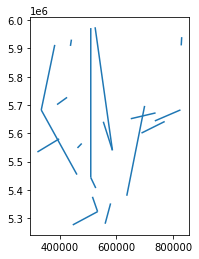

In [136]:
powerlines.plot()

Combine municipalities and powerlines in a plot

In [138]:
powerlines.set_geometry('geometry')
fig, ax = plt.subplots(figsize=(10, 8), dpi=300)
ax.set_aspect('equal')
ax.set_axis_off()
municipalities.plot(ax=ax, color='lightblue', edgecolor='blue', lw=0.01, zorder=1)
states.boundary.plot(ax=ax, color='black', lw = 0.1, zorder=2)
powerlines.plot(ax=ax, color='red', lw=2, zorder=3)
startpoints.plot(ax=ax, color='red', lw=1, zorder=4)
endpoints.plot(ax=ax, color='red', lw=1, zorder=5)
plt.suptitle('BBPlG 2013 projects', fontsize=20)
plt.savefig(f'{path}/figures/BBPLG2013_projects.png')
plt.close()

Now construct the treatment indicator by checking if any of the power lines *directly* intersect with municipality polygons

In [ ]:
municipalities.insert(loc=len(municipalities.columns), column='treated_0', value=0)
for i in range(len(municipalities)):
    municipalities.loc[municipalities.index[i], 'treated_0'] = any(powerlines['geometry'].intersects(municipalities['geometry'].values[i]))

Plot the municipalities that directly intersect with a powerline

In [ ]:
powerlines.set_geometry('geometry')
municipalities_intersected = municipalities[municipalities['treated_0'] == True] #drops all untreated munipalities
fig, ax = plt.subplots(figsize=(10, 8), dpi=300)
ax.set_aspect('equal')
ax.set_axis_off()
municipalities.plot(ax=ax, color='lightblue', edgecolor='blue', lw=0.01, zorder=1)
states.boundary.plot(ax=ax, color='darkblue', lw = 0.1, zorder=2)
municipalities_intersected.plot(ax=ax, color='orange', edgecolor='darkorange', lw=0.01, zorder=3)
powerlines.plot(ax=ax, color='red', lw=2, zorder=4)
plt.suptitle('Municipalities affected by BBPlG 2013 projects', fontsize=20)
plt.title('direct line', fontsize=14)
plt.savefig(f'{path}/figures/BBPLG2013_treated_0.png')
plt.close()


Create buffers around the straight lines to create treatment indicator for different corridor widths

In [ ]:
for buffer in (5, 10, 15, 25, 50):
    try:
        powerlines.insert(loc=len(powerlines.columns), column=f'geometry_{buffer*2}', value=0) #buffer is added on both sides -> x2 to simplify
    except Exception:
        pass
    powerlines[f'geometry_{buffer*2}'] = powerlines['geometry'].buffer(buffer*1000)
powerlines.head()

Now generate treatment indicators for all buffer sizes

In [ ]:
for buffer in (5, 10, 15, 25, 50):
    try:
        municipalities.insert(loc=len(municipalities.columns), column=f'treated_{buffer*2}', value=0)
    except Exception:
        pass
    for i in range(len(municipalities)):
        municipalities.loc[municipalities.index[i], f'treated_{buffer*2}'] = any(powerlines[f'geometry_{buffer*2}'].intersects(municipalities['geometry'].values[i]))
municipalities.head()

Plot for inspection

In [ ]:
#powerlines.set_geometry('geometry_50')
municipalities_intersected50 = municipalities[municipalities['treated_50'] == True] #drops all untreated munipalities
fig, ax = plt.subplots(figsize=(10, 8), dpi=300)
ax.set_aspect('equal')
ax.set_axis_off()
municipalities.plot(ax=ax, color='lightblue', zorder=1)
states.boundary.plot(ax=ax, color='darkblue', lw = 0.1, zorder=2)
municipalities_intersected50.plot(ax=ax, color='orange', edgecolor='darkorange', lw=0.01, zorder=3)
powerlines.plot(ax=ax, color='red', lw=2, zorder=4)
plt.suptitle('Municipalities affected by BBPlG 2013 projects', fontsize=20)
plt.title('with a 50km buffer', fontsize=14)
plt.savefig(f'{path}/figures/BBPLG2013_treated_50.png')
plt.close()

Export treatment dataset from municipalities dataframe

In [ ]:
treatment = pd.DataFrame(municipalities)
treatment = treatment.reindex(columns=['AGS', 'GEN', 'treated_0', 'treated_10', 'treated_20', 'treated_30', 'treated_50', 'treated_100'])
treatment = treatment.set_index('AGS')
treatment = treatment.replace({True:1, False:0})
treatment.to_csv(f'{path}/data/treatment.csv', encoding = 'utf-8-sig')
treatment.head()